<a href="https://colab.research.google.com/github/RomaricKanyamibwa/ForestCoverTypePrediction/blob/master/ForestCoverTypePrediction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.model_selection import KFold,cross_val_score   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Restrict minor warnings
import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [0]:
#Import Data
col_names=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type']

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
covtype=pd.read_csv(data_url,delimiter=",",header =None,names=col_names)

In [3]:
#Distribution des differents Cover Type
tab=covtype["Cover_Type"].value_counts(ascending=True)
print(tab)

4      2747
5      9493
6     17367
7     20510
3     35754
1    211840
2    283301
Name: Cover_Type, dtype: int64


on observe que les données ne sont pas du tout equilibré

# Construction des données equilibré

In [4]:
covtype_balanced=covtype[covtype['Cover_Type']==4].sample(frac=0.79)#(n=2160)
frames = [covtype_balanced]
random.seed(1)
for i in range(1,8):
    if i!=4:
        frames.append(covtype[covtype['Cover_Type']==i].sample(int(len(covtype_balanced)*(1+random.uniform(0.5,1.5)))))
                      
covtype_balanced=pd.concat(frames)
covtype_balanced=covtype_balanced.sample(frac=1)#.reset_index(drop=True)#melange des données
tab=covtype_balanced["Cover_Type"].value_counts(ascending=True)
print(tab)
print("Balanced Data Size:",len(covtype_balanced))

4    2170
1    3546
5    3808
7    4230
6    4330
3    4912
2    5093
Name: Cover_Type, dtype: int64
Balanced Data Size: 28089


In [5]:
covtype_balanced.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,...,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000,28089.000000
mean,2772.654740,158.238456,16.525508,236.275161,52.100182,1771.917868,211.260707,218.878280,136.722632,1571.102887,...,0.045854,0.044110,0.001602,0.007227,0.000427,0.002456,0.050411,0.046531,0.030297,3.979423
std,407.210719,111.401017,8.443595,208.380346,61.366915,1365.534341,31.014905,23.135653,45.423090,1141.973150,...,0.209173,0.205343,0.039994,0.084706,0.020665,0.049503,0.218796,0.210635,0.171405,2.035572
min,1868.000000,0.000000,0.000000,0.000000,-158.000000,0.000000,0.000000,96.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2428.000000,64.000000,10.000000,85.000000,7.000000,765.000000,194.000000,206.000000,109.000000,760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2772.000000,128.000000,15.000000,190.000000,34.000000,1365.000000,218.000000,223.000000,140.000000,1302.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3116.000000,265.000000,22.000000,335.000000,80.000000,2388.000000,234.000000,236.000000,169.000000,2068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3856.000000,360.000000,50.000000,1368.000000,565.000000,7030.000000,254.000000,254.000000,250.000000,7048.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


# Analyse de données 
verifiecation des proprietes vu dans le dataset globale

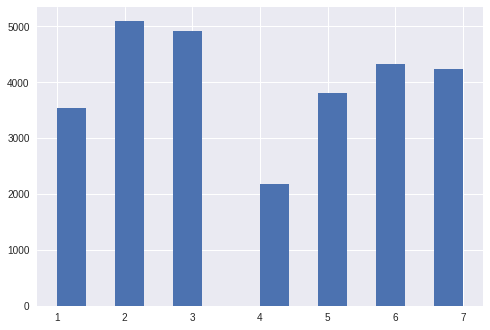

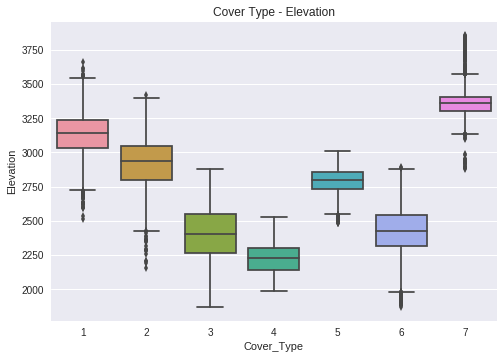

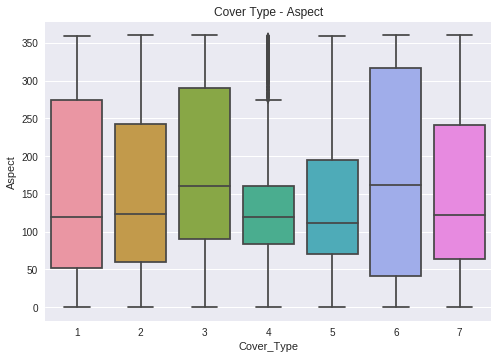

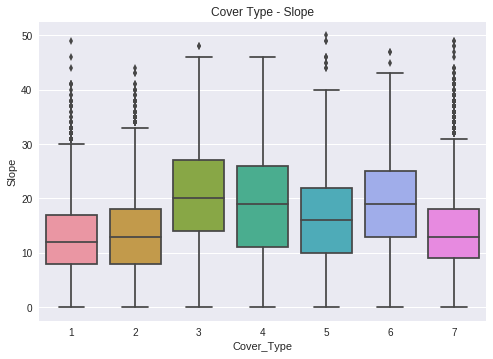

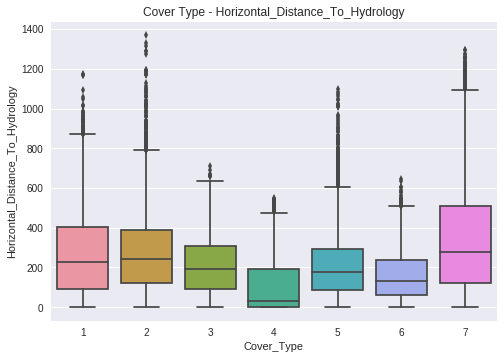

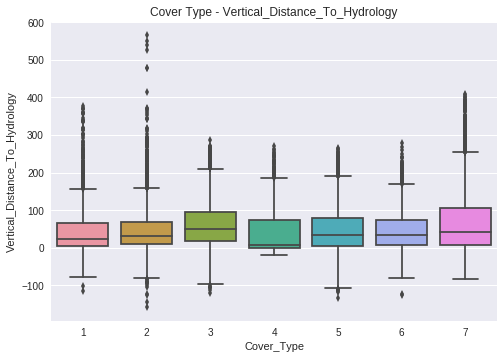

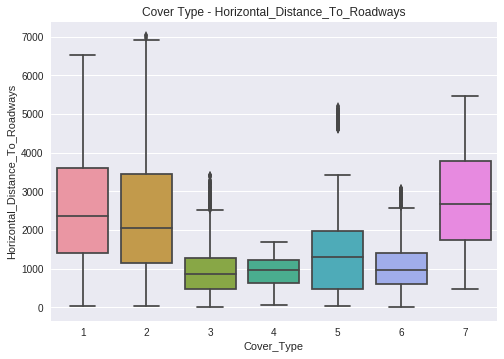

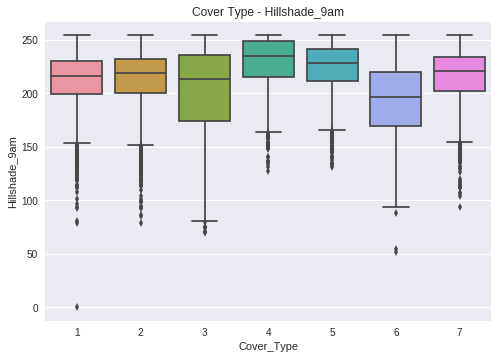

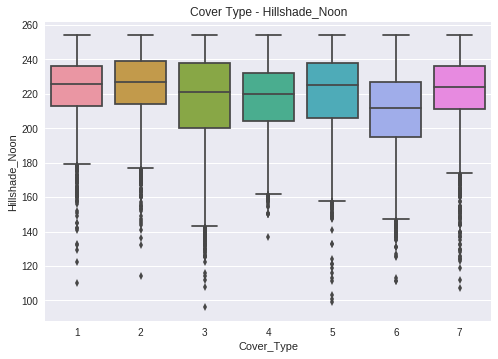

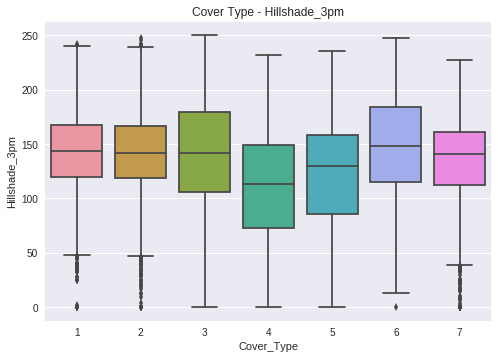

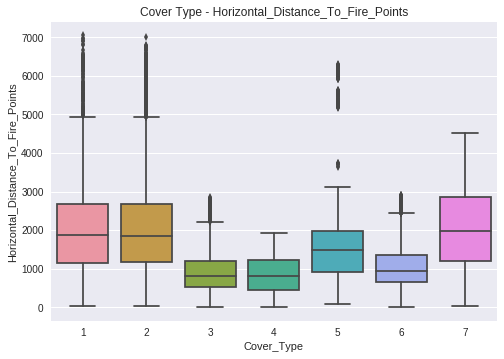

In [6]:
#Histograme 
covtype_balanced['Cover_Type'].hist(bins=2*7);
plt.show()
#sns.boxplot(x="Cover_Type",y="Elevation", data=covtype);
cols = covtype_balanced.columns
size = 10#len(cols) - 1 # on enleve cover_type
# l'axe de x  represente les 7 classes classes
x = cols[-1]
y = cols[0:size]

for i in range(0, size):
    ax=sns.boxplot(data=covtype_balanced, x=x, y=y[i])
    title="Cover Type - "+col_names[i]
    ax.set_title(title)
    #ax = sns.swarmplot(data=covtype, x=x, y=y[i])
    plt.show()

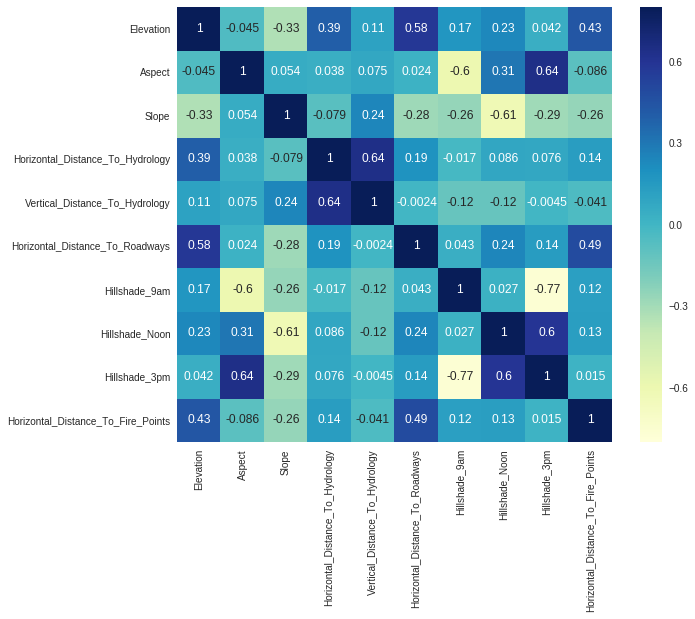

In [24]:
#Matrice de correlation ,on va  étudier l'intensité de la liaison qui peut exister entre les differents variables

size = 10
corrmat = covtype_balanced.iloc[:,:size].corr()
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,cmap="YlGnBu");

# Selection des Variables 
**Feature importances**

In [0]:
#Seletion des variables avec l'attribut feature_importances des arbres de classifications
def best_n_features(data,n=10,n_classes=7):
    X = data.iloc[:,:-1]  #independent columns
    y = data.iloc[:,-1]    #target column i.e price range

    model = ExtraTreesClassifier(n_classes)
    model.fit(X,y)
    #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    #print(list(feat_importances.nlargest(n).index))
    plt.show();
    return (feat_importances)

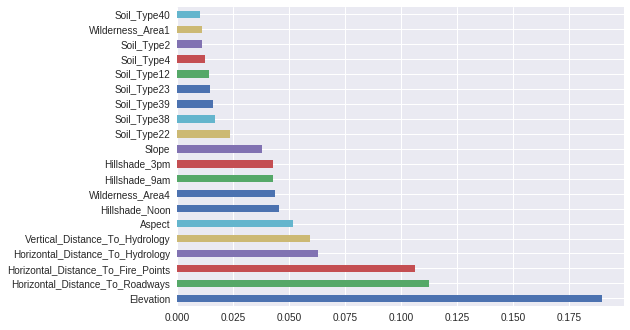

In [9]:
globl_features=best_n_features(covtype,n=20)

**Unvariate feature selection with  chi2**

In [10]:
X = covtype.drop(["Cover_Type","Vertical_Distance_To_Hydrology"],axis=1)  #remove label and negative values
y = covtype.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 15 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features

                                 Specs         Score
4      Horizontal_Distance_To_Roadways  5.766452e+07
8   Horizontal_Distance_To_Fire_Points  3.589090e+07
0                            Elevation  9.479853e+06
3     Horizontal_Distance_To_Hydrology  2.322605e+06
12                    Wilderness_Area4  2.949092e+05
1                               Aspect  2.146782e+05
2                                Slope  1.714326e+05
22                         Soil_Type10  1.219068e+05
16                          Soil_Type4  6.637906e+04
50                         Soil_Type38  6.569458e+04
7                        Hillshade_3pm  6.358794e+04
5                        Hillshade_9am  6.339071e+04
51                         Soil_Type39  6.212286e+04
15                          Soil_Type3  6.109861e+04
14                          Soil_Type2  5.495303e+04


**features selected list**

In [0]:
n_feat=20#number of features
feat=featureScores.nlargest(n_feat,'Score')
list_feat=list(feat['Specs'])
predictors=[list_feat,list(globl_features.nlargest(n_feat).index)] #Our list of features
type_pred=[" Chi2Sel"," FeatImpo"]

# **Construction des Modeles Predictifs**

**Fonction de Train et test **

In [0]:
#fonction generique pour un classifieur et sa performance:
def classification_model(model, train_data,test_data, predictors, outcome,cross_valid=True):
    #entrainement du model:
    tp_d=time()
    model.fit(train_data[predictors],train_data[outcome])
    tr_time = time()-tp_d

    #predictions sur le test set:
    predictions = model.predict(test_data[predictors])

    #affichage de l'accuracy
    accuracy = metrics.accuracy_score(predictions,test_data[outcome])
    print ("\tAccuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 5 folds
    #kf = KFold(n_splits = 10, shuffle = True)#, random_state = 2
    if(cross_valid):
        error = cross_val_score(model,data[predictors],train_data[outcome], cv=5,n_jobs=4)
        print ("\tCross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
        #Fit the model again so that it can be refered outside the function:
        model.fit(train_data[predictors],data[outcome])
    else:
        error=[0]

    return accuracy,tr_time,len(predictors),np.mean(error)

**Scaling Train set**

In [0]:
outcome_var = 'Cover_Type'
end=10 #only categorical variables
scaler = StandardScaler()
#we scale to speed up convergence
scaled_covtype_balanced=covtype_balanced.copy()
scaled_covtype_balanced[col_names[:end]]=scaler.fit_transform(scaled_covtype_balanced[col_names[:end]])
#scaled_covtype_balanced.describe()

**Test Set**

In [14]:
testcovtype=covtype.drop(covtype_balanced.index)
outcome_var = 'Cover_Type'

#Normalisation
end=10 #only categorical variables
scaler = StandardScaler()
#we scale to speed up convergence
testcovtype[col_names[:end]]=scaler.fit_transform(testcovtype[col_names[:end]])
testcovtype.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,5.529230e+05,...,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000,552923.000000
mean,-5.757097e-17,5.839341e-17,2.631816e-17,8.224425e-17,-5.127415e-17,-9.869309e-18,-1.331329e-16,1.891618e-17,-2.779856e-16,-8.224425e-18,...,0.092655,0.079423,0.002832,0.003053,0.000194,0.000414,0.025604,0.022605,0.014286,1.953529
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,0.289948,0.270399,0.053143,0.055168,0.013910,0.020347,0.157951,0.148642,0.118667,1.280777
min,-4.133608e+00,-1.389390e+00,-1.885368e+00,-1.275097e+00,-3.770304e+00,-1.522643e+00,-7.996545e+00,-1.143138e+01,-3.773237e+00,-1.505216e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-5.357669e-01,-8.712462e-01,-6.716703e-01,-7.671510e-01,-6.732659e-01,-8.008417e-01,-4.971116e-01,-5.392034e-01,-6.029645e-01,-7.199164e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.197404e-01,-2.548342e-01,-1.322491e-01,-2.027665e-01,-2.947389e-01,-2.191775e-01,2.189147e-01,1.255774e-01,4.671022e-03,-2.024013e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.268296e-01,9.333223e-01,5.420275e-01,5.591525e-01,3.762861e-01,6.299628e-01,7.088274e-01,6.880841e-01,6.651445e-01,4.264397e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3.311614e+00,1.826673e+00,7.015083e+00,5.295279e+00,9.546961e+00,3.031487e+00,1.575596e+00,1.557413e+00,2.937173e+00,3.890331e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [0]:
TrainingTime=[]
Accuracy=[]
Nb_Features=[]
Classifier=[]
Cross_Validation=[]

In [0]:
names = ["Logit"#,"Lasso"
         ,"Nearest Neighbors", "Linear SVM", "RBF SVM",
         #"Gaussian Process",
         "Decision Tree", "Random Forest 7","Random Forest 100","Random Forest 500",
         "ExtraTreesClassifier 100","ExtraTreesClassifier 500",
         "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter = 450,n_jobs=4),
    #Lasso(alpha=0.1, copy_X=True),
    KNeighborsClassifier(7,n_jobs=4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0),n_jobs=4),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=15,n_jobs=4,bootstrap=True),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=15,n_jobs=4,bootstrap=True),
    RandomForestClassifier(max_depth=5, n_estimators=500, max_features=15,n_jobs=4,bootstrap=True),
    ExtraTreesClassifier(max_depth=5, n_estimators=100, max_features=15,n_jobs=4,bootstrap=True),
    ExtraTreesClassifier(max_depth=5, n_estimators=500, max_features=15,n_jobs=4,bootstrap=True),
    MLPClassifier(alpha= 0.0001,max_iter=450),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

**Training with Chi2 et FeatImpo selection (20 features)**

In [17]:
#predictors=[list_feat] #Our list of features
#type_pred=[" Chi2Sel"]
for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index]," with ",n_feat," best feature(s)","--------")
    for k,pred in enumerate(predictors):
        print("\t---",type_pred[k])
        accuracy,tr_time,nb_features,cross_val=classification_model(
        clsf, train_data=scaled_covtype_balanced,test_data=testcovtype,
        predictors=pred,outcome=outcome_var,cross_valid=False)
  
        classifier_type=names[clsf_index]+type_pred[k]

        TrainingTime.append(tr_time)
        Accuracy.append(accuracy)
        Nb_Features.append(nb_features)
        Classifier.append(classifier_type)
        Cross_Validation.append(cross_val)

-------- Logit  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 37.976%
	---  FeatImpo
	Accuracy : 39.851%
-------- Nearest Neighbors  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 53.179%
	---  FeatImpo
	Accuracy : 53.430%
-------- Linear SVM  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 39.882%
	---  FeatImpo
	Accuracy : 39.168%
-------- RBF SVM  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 58.044%
	---  FeatImpo
	Accuracy : 57.773%
-------- Decision Tree  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 40.392%
	---  FeatImpo
	Accuracy : 39.764%
-------- Random Forest 7  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 43.790%
	---  FeatImpo
	Accuracy : 40.652%
-------- Random Forest 100  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 43.398%
	---  FeatImpo
	Accuracy : 43.989%
-------- Random Forest 500  with  20  best feature(s) --------
	---  Chi2Sel
	Accuracy : 42.726%
	---  FeatImpo

In [18]:
d = {'Type of Classifier':Classifier,'Number of Features':Nb_Features,
     'Training Time': TrainingTime, 'Accuracy': Accuracy,'Cross-Validation':Cross_Validation}

df = pd.DataFrame(data=d)
df = df[list(d.keys())]
df.sort_values(by=['Accuracy'],ascending=False).head(50)

,Type of Classifier,Number of Features,Training Time,Accuracy,Cross-Validation
6,RBF SVM Chi2Sel,20,147.593845,0.580435,0.0
7,RBF SVM FeatImpo,20,177.857041,0.577733,0.0
21,Neural Net FeatImpo,20,201.246059,0.564731,0.0
20,Neural Net Chi2Sel,20,205.082673,0.540039,0.0
3,Nearest Neighbors FeatImpo,20,0.057774,0.534300,0.0
2,Nearest Neighbors Chi2Sel,20,0.058662,0.531788,0.0
13,Random Forest 100 FeatImpo,20,6.007339,0.439886,0.0
18,ExtraTreesClassifier 500 Chi2Sel,20,8.693676,0.439426,0.0
10,Random Forest 7 Chi2Sel,20,0.623534,0.437902,0.0
16,ExtraTreesClassifier 100 Chi2Sel,20,1.785344,0.435424,0.0


**Training with Chi2 et FeatImpo selection (25 features)**

In [19]:
n_feat=25#number of features
feat=featureScores.nlargest(n_feat,'Score')
list_feat=list(feat['Specs'])
predictors=[list_feat,list(globl_features.nlargest(n_feat).index)] #Our list of features
type_pred=[" Chi2Sel"," FeatImpo"]

for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index]," with ",n_feat," best feature(s)","--------")
    for k,pred in enumerate(predictors):
        print("\t---",type_pred[k])
        accuracy,tr_time,nb_features,cross_val=classification_model(
        clsf, train_data=scaled_covtype_balanced,test_data=testcovtype,
        predictors=pred,outcome=outcome_var,cross_valid=False)
  
        classifier_type=names[clsf_index]+type_pred[k]

        TrainingTime.append(tr_time)
        Accuracy.append(accuracy)
        Nb_Features.append(nb_features)
        Classifier.append(classifier_type)
        Cross_Validation.append(cross_val)

-------- Logit  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 40.915%
	---  FeatImpo
	Accuracy : 40.575%
-------- Nearest Neighbors  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 55.842%
	---  FeatImpo
	Accuracy : 56.428%
-------- Linear SVM  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 40.961%
	---  FeatImpo
	Accuracy : 40.280%
-------- RBF SVM  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 59.825%
	---  FeatImpo
	Accuracy : 59.017%
-------- Decision Tree  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 40.309%
	---  FeatImpo
	Accuracy : 39.591%
-------- Random Forest 7  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 41.474%
	---  FeatImpo
	Accuracy : 40.781%
-------- Random Forest 100  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 45.446%
	---  FeatImpo
	Accuracy : 44.943%
-------- Random Forest 500  with  25  best feature(s) --------
	---  Chi2Sel
	Accuracy : 45.475%
	---  FeatImpo

In [25]:
d = {'Type of Classifier':Classifier,'Number of Features':Nb_Features,
     'Training Time': TrainingTime, 'Accuracy': Accuracy,'Cross-Validation':Cross_Validation}

df1 = pd.DataFrame(data=d)
df1 = df1[list(d.keys())]
df1.sort_values(by=['Accuracy'],ascending=False).head(60)

,Type of Classifier,Number of Features,Training Time,Accuracy,Cross-Validation
34,RBF SVM Chi2Sel,25,176.540705,0.598250,0.0
35,RBF SVM FeatImpo,25,215.868554,0.590169,0.0
6,RBF SVM Chi2Sel,20,147.593845,0.580435,0.0
7,RBF SVM FeatImpo,20,177.857041,0.577733,0.0
49,Neural Net FeatImpo,25,204.504870,0.570097,0.0
21,Neural Net FeatImpo,20,201.246059,0.564731,0.0
31,Nearest Neighbors FeatImpo,25,0.073480,0.564285,0.0
30,Nearest Neighbors Chi2Sel,25,0.078339,0.558416,0.0
48,Neural Net Chi2Sel,25,200.036752,0.557515,0.0
20,Neural Net Chi2Sel,20,205.082673,0.540039,0.0


In [0]:
latex=df.sort_values(by=['Accuracy'],ascending=False).head(50).to_latex()
df.to_csv("latex_features20_2.csv")
df.sort_values(by=['Accuracy'],ascending=False).head(50)

,Type of Classifier,Number of Features,Training Time,Accuracy,Cross-Validation
7,RBF SVM FeatImpo,20,54.503555,0.973347,0.802712
6,RBF SVM Chi2Sel,20,30.519669,0.957804,0.812103
17,Neural Net FeatImpo,20,36.862653,0.871429,0.810251
16,Neural Net Chi2Sel,20,42.897423,0.866336,0.813889
2,Nearest Neighbors Chi2Sel,20,0.146458,0.843981,0.770304
3,Nearest Neighbors FeatImpo,20,0.016246,0.841667,0.767791
0,Logit Chi2Sel,20,2.352511,0.694907,0.690013
1,Logit FeatImpo,20,2.440092,0.693254,0.690278
5,Linear SVM FeatImpo,20,3.788670,0.692791,0.688558
4,Linear SVM Chi2Sel,20,4.308234,0.689616,0.685119


In [0]:
d = {'Type of Classifier':Classifier,'Number of Features':Nb_Features,
     'Training Time': TrainingTime, 'Accuracy': Accuracy,'Cross-Validation':Cross_Validation}

df3 = pd.DataFrame(data=d)
df3 = df3[list(d.keys())]
df3.sort_values(by=['Accuracy'],ascending=False).head(50)

,Type of Classifier,Number of Features,Training Time,Accuracy,Cross-Validation
7,RBF SVM FeatImpo,15,82.531964,0.958677,0.812822
6,RBF SVM Chi2Sel,15,52.389378,0.927726,0.824991
2,Nearest Neighbors Chi2Sel,15,0.031588,0.848387,0.776643
3,Nearest Neighbors FeatImpo,15,0.024424,0.842344,0.766558
17,Neural Net FeatImpo,15,54.716731,0.841731,0.808087
16,Neural Net Chi2Sel,15,55.784248,0.836382,0.801103
5,Linear SVM FeatImpo,15,14.386122,0.672234,0.669089
1,Logit FeatImpo,15,4.930157,0.669988,0.666885
4,Linear SVM Chi2Sel,15,15.349996,0.667415,0.664966
0,Logit Chi2Sel,15,5.515417,0.665619,0.662761


In [0]:
for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[1],outcome_var)

-------- Logit  Testing  --------
Accuracy : 37.510%
-------- Nearest Neighbors  Testing  --------
Accuracy : 49.727%
-------- Linear SVM  Testing  --------
Accuracy : 36.521%
-------- RBF SVM  Testing  --------
Accuracy : 58.999%
-------- Decision Tree  Testing  --------
Accuracy : 34.955%
-------- Random Forest 7  Testing  --------
Accuracy : 35.987%
-------- Random Forest 100  Testing  --------
Accuracy : 43.231%
-------- Random Forest 500  Testing  --------
Accuracy : 42.454%
-------- Neural Net  Testing  --------
Accuracy : 53.259%
-------- AdaBoost  Testing  --------
Accuracy : 16.526%
-------- Naive Bayes  Testing  --------
Accuracy : 17.049%
-------- QDA  Testing  --------
Accuracy : 37.053%


In [0]:
for clsf_index,clsf in enumerate(classifiers):
    #for k,pred in enumerate(predictors):
    print("--------",names[clsf_index],type_pred[1]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[1],outcome_var)#,covtype_balanced

-------- Logit  FeatImpo  Testing  --------
	Accuracy : 41.307%
-------- Nearest Neighbors  FeatImpo  Testing  --------
	Accuracy : 54.139%
-------- Linear SVM  FeatImpo  Testing  --------
	Accuracy : 41.404%
-------- RBF SVM  FeatImpo  Testing  --------
	Accuracy : 58.453%
-------- Decision Tree  FeatImpo  Testing  --------
	Accuracy : 32.774%
-------- Random Forest 7  FeatImpo  Testing  --------
	Accuracy : 33.769%
-------- Random Forest 100  FeatImpo  Testing  --------
	Accuracy : 37.289%
-------- Random Forest 500  FeatImpo  Testing  --------
	Accuracy : 38.655%
-------- Neural Net  FeatImpo  Testing  --------
	Accuracy : 55.976%
-------- AdaBoost  FeatImpo  Testing  --------
	Accuracy : 40.603%
-------- Naive Bayes  FeatImpo  Testing  --------
	Accuracy : 11.619%
-------- QDA  FeatImpo  Testing  --------
	Accuracy : 0.133%


In [0]:
for clsf_index,clsf in enumerate(classifiers):
    print("--------",names[clsf_index],type_pred[0]," with ",n_feat," best feature(s)","--------")
    clsf.fit(scaled_covtype_balanced[predictors[0]],scaled_covtype_balanced[outcome_var])
    
    #predictions sur le training set:
    predictions = clsf.predict(scaled_covtype_balanced[predictors[0]])

    #affichage de l'accuracy
    accuracy = metrics.accuracy_score(predictions,scaled_covtype_balanced[outcome_var])
    print ("\tAccuracy : %s" % "{0:.3%}".format(accuracy))

-------- Logit  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 66.562%
-------- Nearest Neighbors  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 84.839%
-------- Linear SVM  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 66.742%
-------- RBF SVM  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 92.773%
-------- Decision Tree  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 63.977%
-------- Random Forest 7  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 59.506%
-------- Random Forest 100  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 63.491%
-------- Random Forest 500  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 63.140%
-------- Neural Net  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 83.932%
-------- AdaBoost  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 45.345%
-------- Naive Bayes  Chi2Sel  with  15  best feature(s) --------
	Accuracy : 43.593%
-------- QDA  Chi2Sel  with  15  best feature

In [0]:
for clsf_index,clsf in enumerate(classifiers):
    #for k,pred in enumerate(predictors):
    print("--------",names[clsf_index],type_pred[0]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[0],outcome_var)#,covtype_balanced

-------- Logit  Chi2Sel  Testing  --------
	Accuracy : 40.498%
-------- Nearest Neighbors  Chi2Sel  Testing  --------
	Accuracy : 52.181%
-------- Linear SVM  Chi2Sel  Testing  --------
	Accuracy : 40.852%
-------- RBF SVM  Chi2Sel  Testing  --------
	Accuracy : 56.583%
-------- Decision Tree  Chi2Sel  Testing  --------
	Accuracy : 33.879%
-------- Random Forest 7  Chi2Sel  Testing  --------
	Accuracy : 37.504%
-------- Random Forest 100  Chi2Sel  Testing  --------
	Accuracy : 39.028%
-------- Random Forest 500  Chi2Sel  Testing  --------
	Accuracy : 37.288%
-------- Neural Net  Chi2Sel  Testing  --------
	Accuracy : 48.264%
-------- AdaBoost  Chi2Sel  Testing  --------
	Accuracy : 30.176%
-------- Naive Bayes  Chi2Sel  Testing  --------
	Accuracy : 7.757%
-------- QDA  Chi2Sel  Testing  --------
	Accuracy : 37.243%


In [0]:
for clsf_index,clsf in enumerate(classifiers):
    #for k,pred in enumerate(predictors):
    print("--------",names[clsf_index],type_pred[0]," Testing ","--------")
    test_model(clsf,testcovtype,predictors[0],outcome_var)#,covtype_balanced

-------- Logit  Chi2Sel  Testing  --------
	Accuracy : 42.113%
-------- Nearest Neighbors  Chi2Sel  Testing  --------
	Accuracy : 56.954%
-------- Linear SVM  Chi2Sel  Testing  --------
	Accuracy : 42.879%
-------- RBF SVM  Chi2Sel  Testing  --------
	Accuracy : 59.829%
-------- Decision Tree  Chi2Sel  Testing  --------
	Accuracy : 41.632%
-------- Random Forest 7  Chi2Sel  Testing  --------
	Accuracy : 35.137%
-------- Random Forest 100  Chi2Sel  Testing  --------
	Accuracy : 37.004%
-------- Random Forest 500  Chi2Sel  Testing  --------
	Accuracy : 38.762%
-------- Neural Net  Chi2Sel  Testing  --------
	Accuracy : 58.438%
-------- AdaBoost  Chi2Sel  Testing  --------
	Accuracy : 30.175%
-------- Naive Bayes  Chi2Sel  Testing  --------
	Accuracy : 6.617%
-------- QDA  Chi2Sel  Testing  --------
	Accuracy : 37.243%
